In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [4]:
df = pd.read_csv('../input/bitcoin-price-prediction/bitcoin_price_Training - Training.csv')
df

,Date,Open,High,Low,Close,Volume,Market Cap
0,"Jul 31, 2017",2763.24,2889.62,2720.61,2875.34,"860,575,000","45,535,800,000"
1,"Jul 30, 2017",2724.39,2758.53,2644.85,2757.18,"705,943,000","44,890,700,000"
2,"Jul 29, 2017",2807.02,2808.76,2692.80,2726.45,"803,746,000","46,246,700,000"
3,"Jul 28, 2017",2679.73,2897.45,2679.73,2809.01,"1,380,100,000","44,144,400,000"
4,"Jul 27, 2017",2538.71,2693.32,2529.34,2671.78,"789,104,000","41,816,500,000"
...,...,...,...,...,...,...,...
1551,"May 02, 2013",116.38,125.60,92.28,105.21,-,"1,292,190,000"
1552,"May 01, 2013",139.00,139.89,107.72,116.99,-,"1,542,820,000"
1553,"Apr 30, 2013",144.00,146.93,134.05,139.00,-,"1,597,780,000"
1554,"Apr 29, 2013",134.44,147.49,134.00,144.54,-,"1,491,160,000"


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1556 entries, 0 to 1555
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        1556 non-null   object 
 1   Open        1556 non-null   float64
 2   High        1556 non-null   float64
 3   Low         1556 non-null   float64
 4   Close       1556 non-null   float64
 5   Volume      1556 non-null   object 
 6   Market Cap  1556 non-null   object 
dtypes: float64(4), object(3)
memory usage: 85.2+ KB


In [6]:
df.Date = pd.to_datetime(df["Date"])
df.Date.dtype

dtype('<M8[ns]')

In [7]:
print('Date starts: ',df.Date.min())
print('Date ends: ',df.Date.max())

Date starts:  2013-04-28 00:00:00
Date ends:  2017-07-31 00:00:00


In [8]:
df.describe()

,Open,High,Low,Close
count,1556.000000,1556.000000,1556.000000,1556.000000
mean,582.625328,597.992847,567.851446,584.239396
std,523.137312,542.992855,505.877401,525.904442
min,68.500000,74.560000,65.530000,68.430000
25%,254.287500,260.327500,248.835000,254.320000
50%,438.600000,447.560000,430.570000,438.855000
75%,662.437500,674.525000,646.735000,663.402500
max,2953.220000,2999.910000,2840.530000,2958.110000


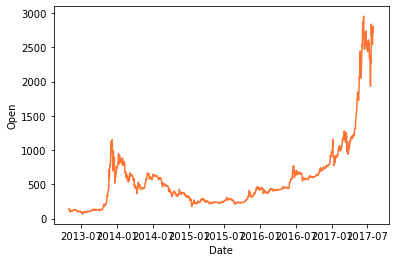

In [9]:
sns.lineplot(df.Date,df.Open,color='#FF7433')

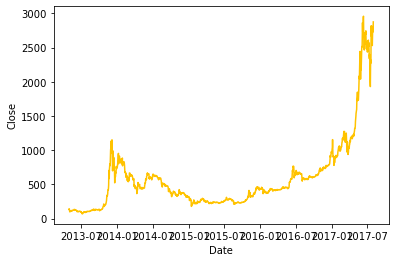

In [10]:
sns.lineplot(df.Date,df.Close,color='#FFC300')

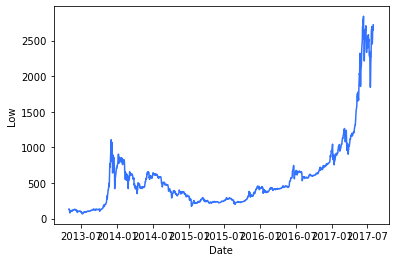

In [11]:
sns.lineplot(df.Date,df.Low,color='#3371FF')

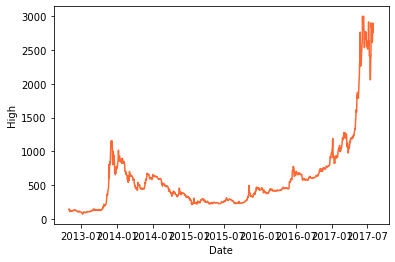

In [12]:
sns.lineplot(df.Date,df.High,color='#FF6833')

We are just going to perform stationarity, decomposition,and dickey-fuller test on Open only...generally if one feature is stationary othes too.

In [13]:
y = df[['Date','Open']]

In [14]:
y = y.set_index('Date')

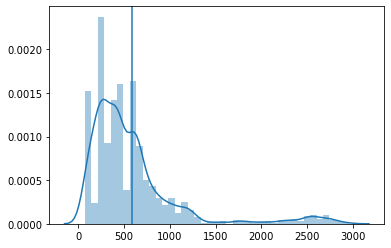

In [15]:
sns.distplot(y)
plt.axvline(y.Open.mean())

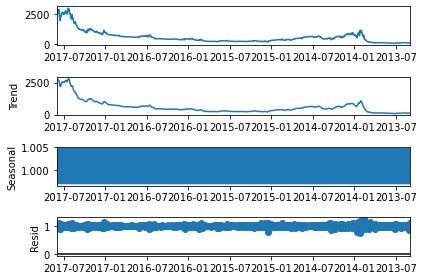

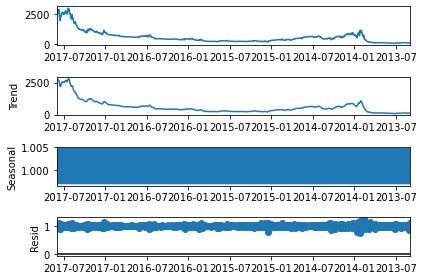

In [16]:
# time series

import statsmodels.api as sm
decomposition = sm.tsa.seasonal_decompose(y,model='multiplicative')
decomposition.plot()

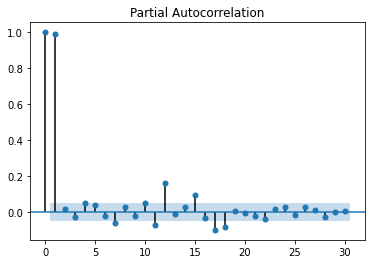

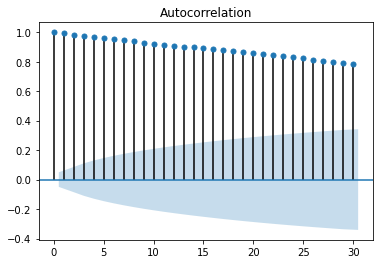

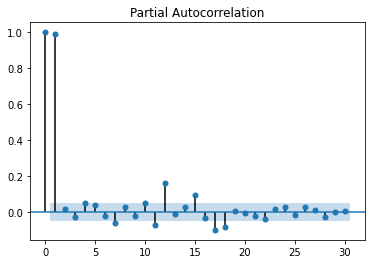

In [17]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

plot_acf(y,lags=30)
plot_pacf(y,lags=30)

In [18]:
# plot rolling means and standard deviation

from statsmodels.tsa.stattools import adfuller

def test_stationarity(y):
  rol_mean = y.rolling(12).mean()
  rol_std = y.rolling(12).std()

  plt.subplots(figsize=(15,8))
  plt.plot(rol_mean,color='red',label='rolling_mean')
  plt.plot(rol_std,color='black',label='rolling_std')
  plt.plot(y,color='blue',label='original')
  plt.legend(loc='best')
  plt.show()

  df_test = adfuller(y.Open,autolag='AIC')
  df_output = pd.Series(df_test[0:4],index=['test stats','p-value','#lags','no. of oservations used'])
  print(df_output)

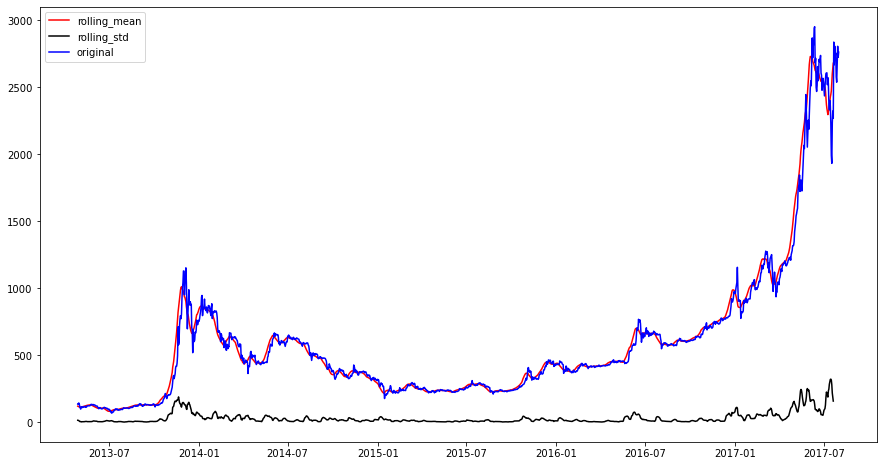

test stats                   -4.876850
p-value                       0.000039
#lags                        24.000000
no. of oservations used    1531.000000
dtype: float64


In [19]:
test_stationarity(y)

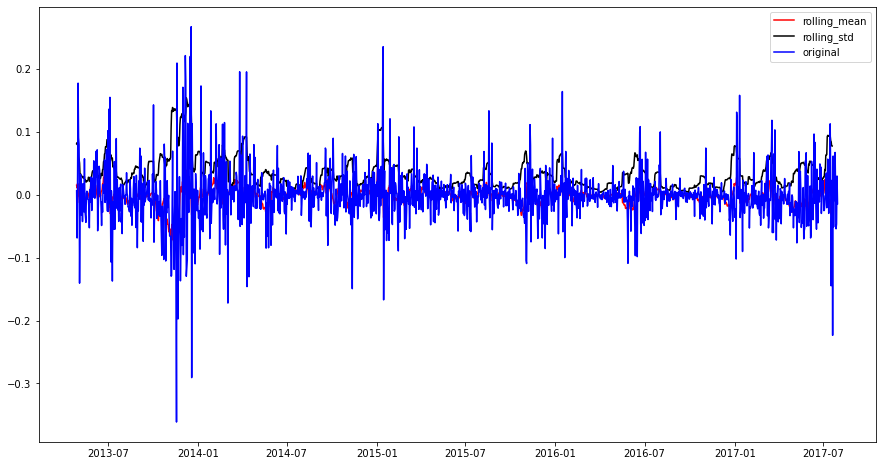

test stats                -7.225681e+00
p-value                    2.056093e-10
#lags                      2.200000e+01
no. of oservations used    1.532000e+03
dtype: float64


In [22]:
# it is already stationary data
# but it was not then we have to perform some processing, anyways we are applying it here too.

y_log = np.log(y)

s_data = y_log - y_log.shift(1)
s_data = s_data.dropna()
test_stationarity(s_data)

In [23]:
#create training data

train_prophet = pd.DataFrame()
train_prophet['ds'] = y.index
train_prophet['y'] = y.Open.values

In [24]:
# create model to predict the future openings

from fbprophet import Prophet

model = Prophet().fit(train_prophet)

future = model.make_future_dataframe(periods=90)

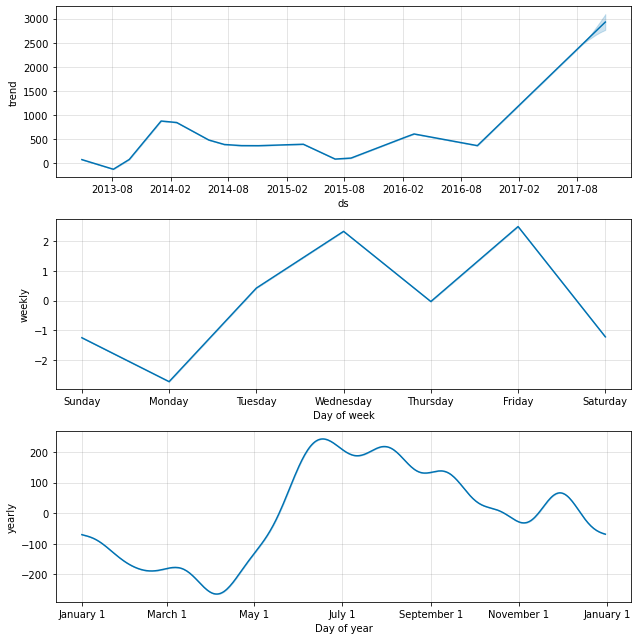

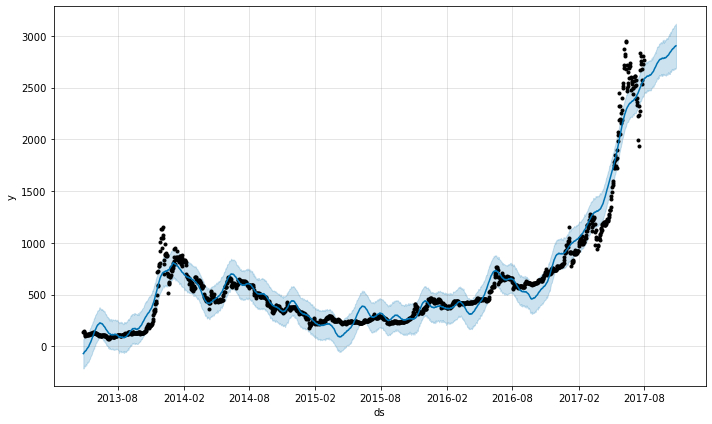

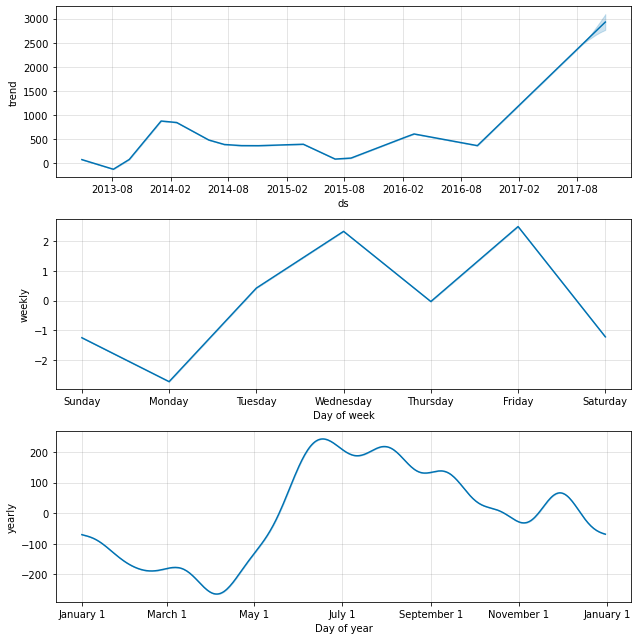

In [25]:
forecast = model.predict(future)
model.plot(forecast)
model.plot_components(forecast)

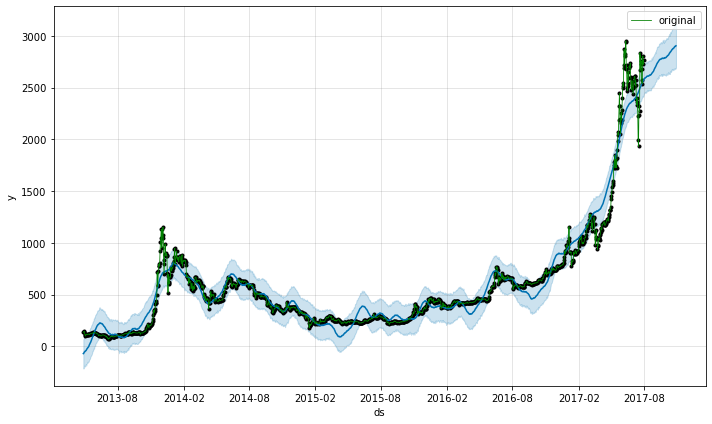

In [26]:
#compare the predicted with original dataset

model.plot(forecast)
plt.plot(y,label='original',color='green',linewidth=0.8)
plt.legend(loc='best')
plt.show()

In [27]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2013-04-28,-71.444582,-216.050356,68.386098
1,2013-04-29,-68.737088,-214.315269,70.138840
2,2013-04-30,-61.476671,-187.405460,84.891933
3,2013-05-01,-55.494367,-196.793672,94.949856
4,2013-05-02,-53.788659,-191.510371,87.603201


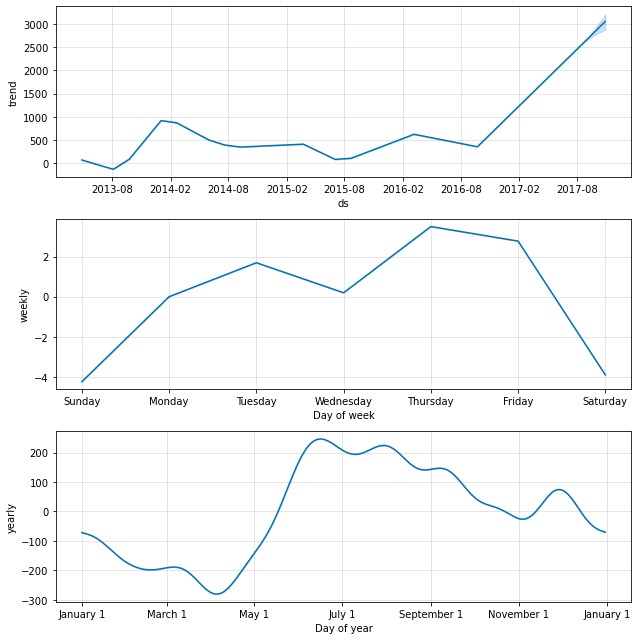

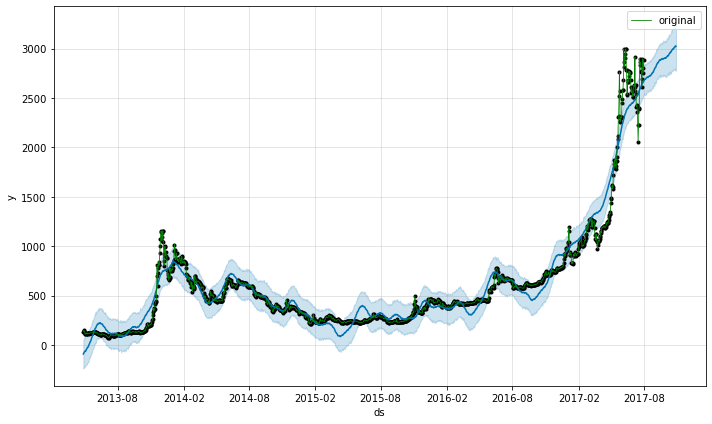

In [28]:
y = df[['Date','High']]
y = y.set_index('Date')

#create training data

train_prophet = pd.DataFrame()
train_prophet['ds'] = y.index
train_prophet['y'] = y.High.values

model = Prophet().fit(train_prophet)

future = model.make_future_dataframe(periods=90)

forecast = model.predict(future)
model.plot_components(forecast)

#compare the predicted with original dataset

model.plot(forecast)
plt.plot(y,label='original',color='green',linewidth=0.8)
plt.legend(loc='best')
plt.show()

In [29]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2013-04-28,-90.588597,-237.732133,43.556173
1,2013-04-29,-81.705821,-228.600137,66.166789
2,2013-04-30,-75.371109,-233.558991,63.119155
3,2013-05-01,-72.206836,-213.384745,79.429256
4,2013-05-02,-64.198547,-222.036214,78.688025


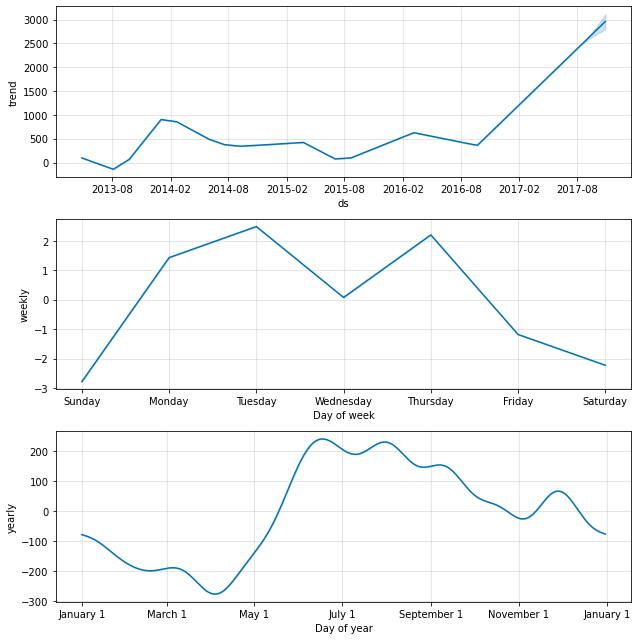

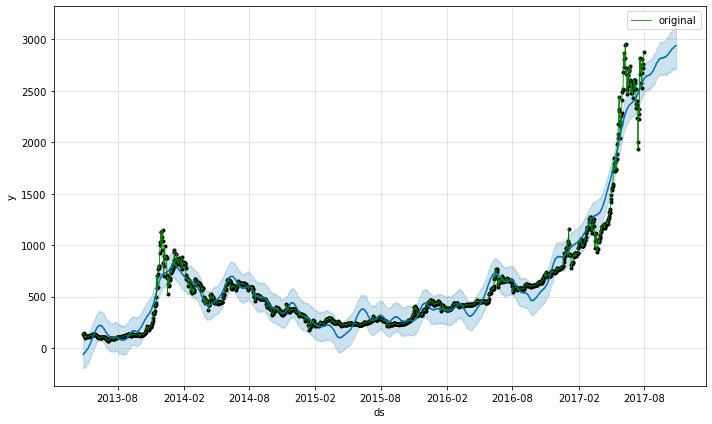

In [30]:
y = df[['Date','Close']]
y = y.set_index('Date')

#create training data

train_prophet = pd.DataFrame()
train_prophet['ds'] = y.index
train_prophet['y'] = y.Close.values

model = Prophet().fit(train_prophet)

future = model.make_future_dataframe(periods=90)

forecast = model.predict(future)
model.plot_components(forecast)

#compare the predicted with original dataset

model.plot(forecast)
plt.plot(y,label='original',color='green',linewidth=0.8)
plt.legend(loc='best')
plt.show()

In [31]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2013-04-28,-62.714862,-199.252513,77.001182
1,2013-04-29,-54.697576,-196.254012,69.283035
2,2013-04-30,-49.832865,-188.031182,94.400819
3,2013-05-01,-48.399800,-182.338773,97.843180
4,2013-05-02,-42.386027,-173.090554,96.713814


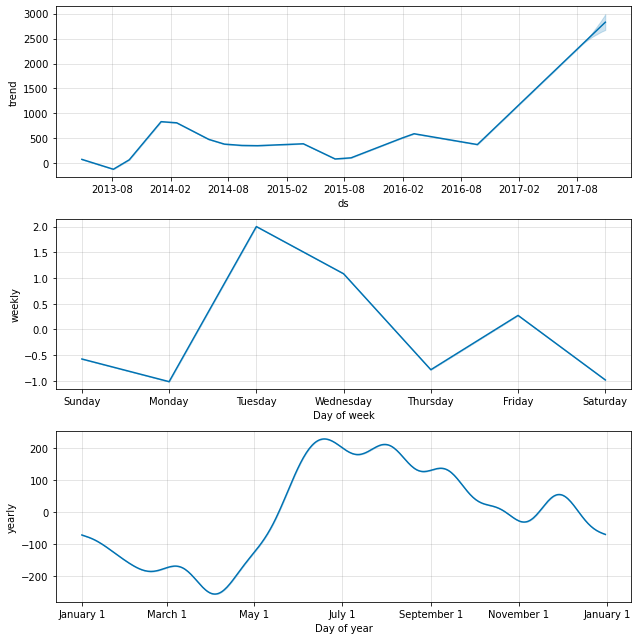

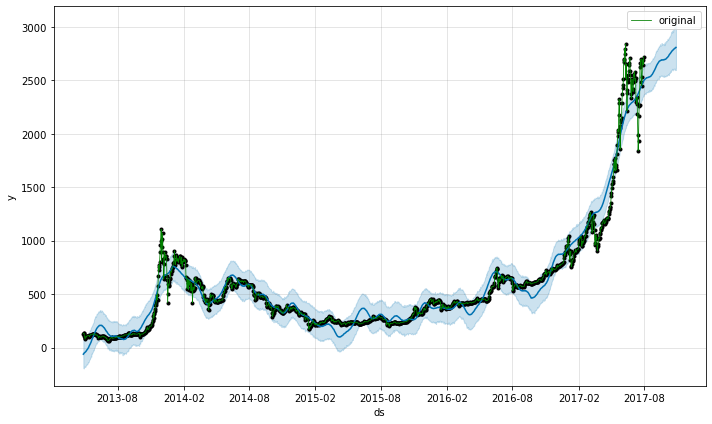

In [32]:
y = df[['Date','Low']]
y = y.set_index('Date')

#create training data

train_prophet = pd.DataFrame()
train_prophet['ds'] = y.index
train_prophet['y'] = y.Low.values

model = Prophet().fit(train_prophet)

future = model.make_future_dataframe(periods=90)

forecast = model.predict(future)
model.plot_components(forecast)

#compare the predicted with original dataset

model.plot(forecast)
plt.plot(y,label='original',color='green',linewidth=0.8)
plt.legend(loc='best')
plt.show()

In [33]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2013-04-28,-61.177260,-188.020089,78.471984
1,2013-04-29,-58.085501,-195.576482,79.916154
2,2013-04-30,-51.555828,-185.335918,81.365119
3,2013-05-01,-48.947252,-175.453445,82.414350
4,2013-05-02,-47.241870,-180.112480,85.435172


In [34]:
#interactive graph s
from fbprophet.plot import plot_plotly, plot_components_plotly
plot_components_plotly(model,forecast)

In [35]:
plot_plotly(model, forecast)